# 삼성전자 주식 종가 예측 프로그램


- 삼성전자 2005년 1월 3일 ~ 2024년 5월 30일까지 데이터를 LSTM 모델을 이용해서 학습해서 주가를 예측한다.

In [1]:
!pip install tensorflow

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation, Input
#from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime

## Load Dataset

In [3]:
data = pd.read_csv('dataset/KOSPI.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-01-03,896.000000,897.590027,890.929993,893.710022,893.710022,252600.0
1,2005-01-04,890.559998,895.400024,884.940002,886.900024,886.900024,331600.0
2,2005-01-05,874.919983,885.200012,873.179993,885.190002,885.190002,343100.0
3,2005-01-06,878.229980,886.309998,871.280029,871.280029,871.280029,394700.0
4,2005-01-07,876.359985,878.890015,866.719971,870.840027,870.840027,294800.0


## 중간 값 구하기

- 주식의 high값과 Low값을 나눠서 중간값 구한다.

In [4]:
high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices) / 2

## Create Windows

- 50일간의 데이터를 학습하고 다음 날의 주가를 예측

In [5]:
seq_len = 60 # 60일간의 데이터를 저장
sequence_length = seq_len + 1

result = []
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])

## 데이터 정규화 작업

- 모델을 좀 더 잘 예측하게 하기 위해서

In [6]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window] # 주식 종가율 예측 정규화식
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# 훈련 데이터와 테스트 데이터 분할
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((4278, 60, 1), (475, 60, 1))

4287일의 데이터를 학습해서 476일의 데이터 주식 가격을 예측한다.

## Build a Model

In [7]:
model = Sequential()

model.add(LSTM(60, return_sequences=True, input_shape=(60, 1)))

model.add(LSTM(128, return_sequences=False))

model.add(Dense(1, activation='linear')) # 다음날 하루의 주가를 예측

model.compile(loss='mse', optimizer='rmsprop')

model.summary()

C:\Users\bin00\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 60)         │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │        96,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,777 (436.63 KB)

 Trainable params: 111,777 (436.63 KB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [8]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=64,
    epochs=100)

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0041 - val_loss: 9.8326e-04
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0014 - val_loss: 6.5238e-04
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0012 - val_loss: 6.0775e-04
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0011 - val_loss: 5.4892e-04
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0010 - val_loss: 5.4187e-04
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 9.7118e-04 - val_loss: 7.7709e-04
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 9.2395e-04 - val_loss: 4.7441e-04
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 8.3382e-04 - val_loss: 4.5364e-04
Epoch 9/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 8.3386e-04 - val_loss: 4.9757e-04
Epoch 10/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 8.2934e-04 - val_loss: 4.8258e-04
Epoch 11/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 7.6155e-04 - val_l

## AI 예측 결과

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


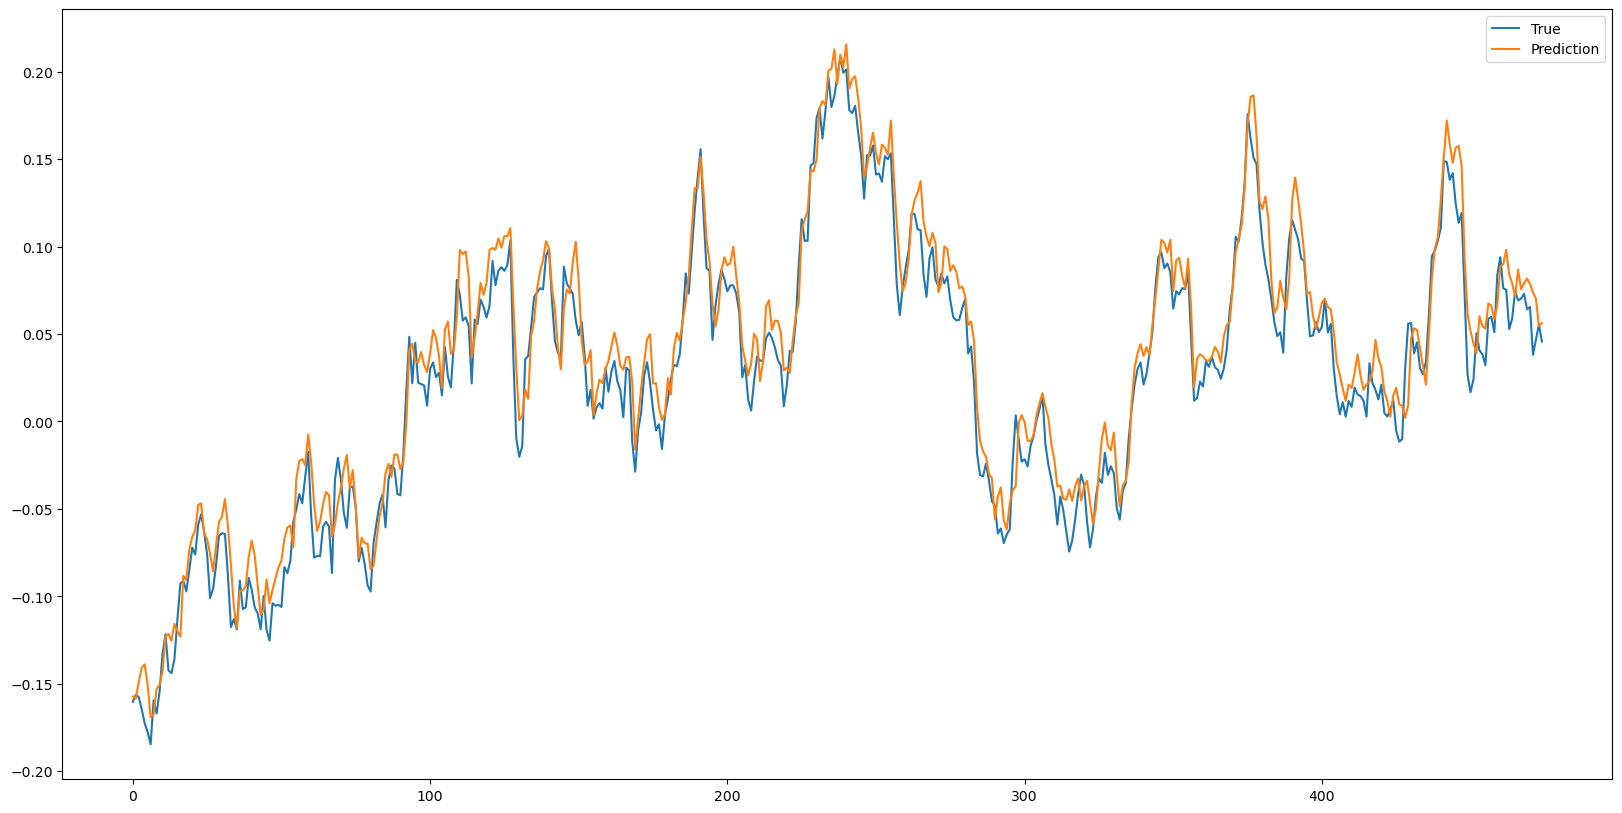

In [9]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()